In [23]:
## 导入各种库
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# 下载数据并将所有数据转换为 𝐓𝐞𝐧𝐬𝐨𝐫 ，train为是否训练数据集，download默认网上下载
data_path='D:\深度学习课件（刘）\PPT 2023春\experiment\homework'  # 根据需要自己定义路径
mnist_train = torchvision.datasets.FashionMNIST(data_path, train=True, download=False, transform=transforms.ToTensor()) 
mnist_test = torchvision.datasets.FashionMNIST(data_path, train=False, download=False, transform=transforms.ToTensor())



In [25]:
img_t,label = mnist_train[101]
img_t.shape,label

(torch.Size([1, 28, 28]), 0)

In [26]:
# 通过 𝐃𝐚𝐭𝐚𝐋𝐨𝐚𝐝𝐞𝐫 读取小批量数据样本，shuffle是否打乱顺序，num_workers为进程的个数
batch_size = 128 
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) 
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)
len(train_iter)

469

In [27]:
## 参数初始化
num_inputs = 784# 拉成向量的长度
num_hiddens=256 #隐藏层的神经元数
num_outputs = 10# 分类的类别个数
W1 = torch.normal(0, 0.01, size=(num_inputs, num_hiddens))# 权重的高斯随机初始化
b1 = torch.zeros(num_hiddens)                             # 偏移的随机初始化
W2 = torch.normal(0, 0.01, size=(num_hiddens, num_outputs))# 权重的高斯随机初始化
b2 = torch.zeros(num_outputs)  
params=[W1,b1,W2,b2]

for param in params:
    param.requires_grad_(requires_grad=True)

In [28]:
#选用常用ReLU作为激活函数
#def relu(z):
 #   z=np.where(z>0,z,0)
 #   return  torch.tensor(z)
def relu(X): # 激活函数
    return torch.max(input=X, other=torch.tensor(0.0))
    # 使用基础的max函数来实现ReLU，而非直接调用relu函数

In [29]:
## 网络
# 定义Softmax
def softmax(X):
    return torch.exp(X) / torch.exp(X).sum()  # 这里应用了广播机制


In [30]:
# 定义网络模型

def net(X): # 定义模型结构
    X = X.view((-1, num_inputs)) # view函数将每张原始图像改成长度为num_inputs的向量
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2
#    return nn.LogSoftmax(torch.matmul(H, W2) + b2)


In [31]:
## 交叉熵损失
loss = torch.nn.CrossEntropyLoss() # 损失函数  
## 交叉熵损失
#loss=nn.NLLloss()

In [32]:
## 梯度下降
def sgd(params, lr, batch_size): 
    for param in params: 
        param.data -= lr * param.grad / batch_size  # 注意这里更改param时用的param.data

In [33]:
#计算模型在某个数据集上的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (softmax(net(X)).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n           


In [36]:
#定义模型训练函数
def train(net, train_iter, test_iter, num_epochs, batch_size,
              params, optimizer = None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y_hat in train_iter:
            y = net(X)
            yt=softmax(y)
            l = loss(y,y_hat).sum()         

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad() # 这里我们用到优化器，所以直接对优化器行梯度清零
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # 用到优化器这里


            train_l_sum += l.item()
            train_acc_sum += (yt.argmax(dim=1) == y_hat).sum().item()
            n += y_hat.shape[0] 
        test_acc = evaluate_accuracy(test_iter, net)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

        # 记录loss
        return float(train_l_sum/n), float(test_acc)

In [38]:
## 模型训练
lr = 0.1 
num_epochs = 10 # 迭代次数
train(net, train_iter, test_iter,  num_epochs, batch_size, params)

epoch 1, loss 0.0155, train acc 0.456, test acc 0.469
epoch 2, loss 0.0145, train acc 0.482, test acc 0.487
epoch 3, loss 0.0136, train acc 0.495, test acc 0.492
epoch 4, loss 0.0127, train acc 0.518, test acc 0.547
epoch 5, loss 0.0119, train acc 0.574, test acc 0.574
epoch 6, loss 0.0112, train acc 0.594, test acc 0.593
epoch 7, loss 0.0106, train acc 0.612, test acc 0.603
epoch 8, loss 0.0101, train acc 0.618, test acc 0.619
epoch 9, loss 0.0097, train acc 0.630, test acc 0.620
epoch 10, loss 0.0092, train acc 0.636, test acc 0.628


In [45]:
# 开始利用 pytorch 构建模块 
import torch
import torch.nn as nn
import torch.optim as optim


In [46]:
# 加载训练集和测试集
batch_size = 128 
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True) 
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
len(train_iter)

469

In [47]:
## 参数初始化
num_inputs = 784# 拉成向量的长度
num_hiddens= 30 #隐藏层的神经元数
num_outputs = 10# 分类的类别个数

In [48]:
# 定义平铺层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
         super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)  # -1可以换成784

In [49]:
# 利用模块搭建网络
net1 = nn.Sequential(
            FlattenLayer(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs)
            )


In [50]:
optimizer = optim.SGD(net1.parameters(),lr)   # torch 优化器
## 交叉熵损失
loss_c = nn.CrossEntropyLoss() # 损失函数  

In [51]:
#计算模型在某个数据集上的准确率
def evaluate_accuracy1(data_iter, net,loss):
    l_sum=0.0
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (softmax(net(X)).argmax(dim=1) == y).sum().item()
        l=loss(net(X),y).sum()
        l_sum+=l.item()
        n += y.shape[0]
    return acc_sum / n, l_sum / n         


In [ ]:
#  训练
n_epochs=100
learning_rate=0.1

optimizer = optim.SGD(net1.parameters(),lr=learning_rate)   # torch 优化器
loss_c = nn.CrossEntropyLoss() # 损失函数

train_loss_x = []
train_loss_y = []
test_loss_x = []
test_loss_y = []

for epoch in range(n_epochs+1):    
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y_hat in train_iter:
        y = net1(X)
        yt=softmax(y)
        l = loss_c(y,y_hat)   # 小批量中损失
#        print(l.data.item())     
        optimizer.zero_grad() # 直接对优化器行梯度清零 
        l.backward()
        optimizer.step()
          
        train_l_sum += l.item() # 一个周期的损失求和，最后为了求平均
        train_acc_sum += (yt.argmax(dim=1) == y_hat).sum().item() # 训练集上准确率
        n += y_hat.shape[0] 
    test_acc,test_loss = evaluate_accuracy1(test_iter, net1, loss_c)     # 测试集上准确率
   
    train_loss=train_l_sum / n
    train_loss_x.append(epoch+1)
    train_loss_y.append(train_loss)
    test_loss_x.append(epoch+1)
    test_loss_y.append(test_loss)
    
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))           

epoch 1, loss 0.0059, train acc 0.740, test acc 0.798
epoch 2, loss 0.0039, train acc 0.823, test acc 0.824
epoch 3, loss 0.0035, train acc 0.841, test acc 0.800
epoch 4, loss 0.0033, train acc 0.849, test acc 0.846
epoch 5, loss 0.0032, train acc 0.855, test acc 0.843
epoch 6, loss 0.0031, train acc 0.860, test acc 0.846
epoch 7, loss 0.0030, train acc 0.865, test acc 0.854
epoch 8, loss 0.0029, train acc 0.868, test acc 0.853
epoch 9, loss 0.0028, train acc 0.870, test acc 0.842
epoch 10, loss 0.0028, train acc 0.873, test acc 0.858
epoch 11, loss 0.0027, train acc 0.877, test acc 0.857
epoch 12, loss 0.0027, train acc 0.876, test acc 0.860
epoch 13, loss 0.0026, train acc 0.879, test acc 0.857
epoch 14, loss 0.0026, train acc 0.881, test acc 0.863
epoch 15, loss 0.0025, train acc 0.882, test acc 0.856
epoch 16, loss 0.0025, train acc 0.886, test acc 0.865
epoch 17, loss 0.0025, train acc 0.885, test acc 0.867
epoch 18, loss 0.0025, train acc 0.886, test acc 0.860
epoch 19, loss 0.00

In [ ]:
#print(test_loss_x)
#print(test_loss_y)
#print(train_loss_x)
#print(train_loss_y)

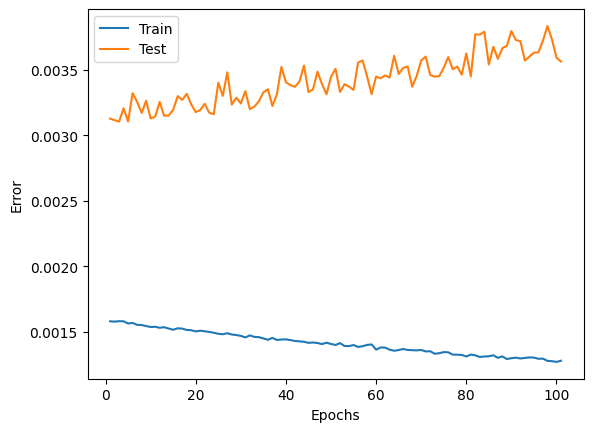

In [95]:
# -- 用图表表示误差的记录 -- 
plt.plot(train_loss_x, train_loss_y, label="Train")
plt.plot(test_loss_x, test_loss_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [ ]:
# -- 用图表表示误差的记录 -- 
plt.plot(train_loss_x, train_loss_y, label="Train")
#plt.plot(test_loss_x, test_loss_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [118]:
#  代码封装 

learning_rate=0.1

optimizer = optim.SGD(net1.parameters(),lr=learning_rate)   # torch 优化器
loss_c = nn.CrossEntropyLoss() # 损失函数

train_loss_x1 = []
train_loss_y1 = []
test_loss_x1 = []
test_loss_y1 = []        
   

def train(net1, train_iter,test_iter, optimizer, epoch):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y_hat in train_iter:
        y = net1(X)
        yt=softmax(y)
        l = loss_c(y,y_hat)   # 小批量中损失
#        print(l.data.item())     
        optimizer.zero_grad() # 直接对优化器行梯度清零 
        l.backward()
        optimizer.step()
          
        train_l_sum += l.item() # 一个周期的损失求和，最后为了求平均
        train_acc_sum += (yt.argmax(dim=1) == y_hat).sum().item() # 训练集上准确率
        n += y_hat.shape[0] 
    
    test_acc,test_loss = evaluate_accuracy1(test_iter, net1, loss_c)     # 测试集上准确率
   
    train_loss=train_l_sum / n
    train_loss_x1.append(epoch+1)
    train_loss_y1.append(train_loss)
    test_loss_x1.append(epoch+1)
    test_loss_y1.append(test_loss)
    
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc)) 
   
    return train_loss_x1,train_loss_y1,test_loss_x1,test_loss_y1

In [119]:
n_epochs=100
for epoch in range(n_epochs+1):
    train(net1, train_iter,test_iter, optimizer, epoch)

print(train_loss_x1)

epoch 1, loss 0.0012, train acc 0.944, test acc 0.865
epoch 2, loss 0.0012, train acc 0.944, test acc 0.867
epoch 3, loss 0.0012, train acc 0.946, test acc 0.863
epoch 4, loss 0.0012, train acc 0.944, test acc 0.865
epoch 5, loss 0.0012, train acc 0.945, test acc 0.867
epoch 6, loss 0.0012, train acc 0.946, test acc 0.868
epoch 7, loss 0.0012, train acc 0.946, test acc 0.867
epoch 8, loss 0.0012, train acc 0.945, test acc 0.864
epoch 9, loss 0.0012, train acc 0.946, test acc 0.863
epoch 10, loss 0.0012, train acc 0.946, test acc 0.865
epoch 11, loss 0.0012, train acc 0.945, test acc 0.860
epoch 12, loss 0.0012, train acc 0.945, test acc 0.868
epoch 13, loss 0.0012, train acc 0.946, test acc 0.864
epoch 14, loss 0.0012, train acc 0.947, test acc 0.868
epoch 15, loss 0.0012, train acc 0.946, test acc 0.865
epoch 16, loss 0.0012, train acc 0.946, test acc 0.868
epoch 17, loss 0.0012, train acc 0.947, test acc 0.863
epoch 18, loss 0.0012, train acc 0.946, test acc 0.867
epoch 19, loss 0.00

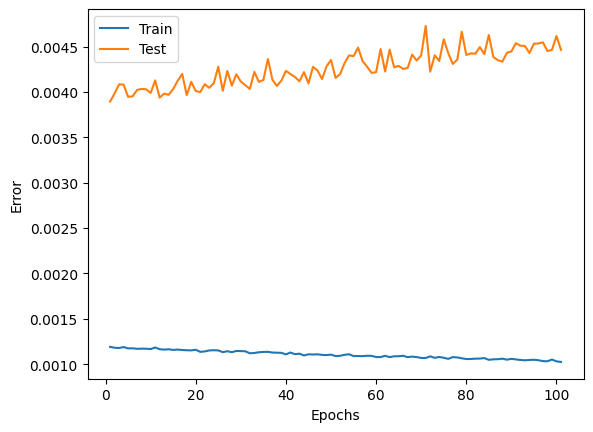

In [120]:
# -- 用图表表示误差的记录 -- 
plt.plot(train_loss_x1, train_loss_y1, label="Train")
plt.plot(test_loss_x1, test_loss_y1, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [154]:
#  cuda 运算
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')) # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多


In [155]:
# 利用模块搭建网络
net1 = nn.Sequential(
            FlattenLayer(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs)
            )
net1=net1.to(device)

In [156]:
#计算模型在某个数据集上的准确率  cuda
def evaluate_accuracy1(data_iter,device, net,loss):
    l_sum=0.0
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        X=X.to(device)
        y=y.to(device)
        acc_sum += (softmax(net(X)).argmax(dim=1) == y).sum().item()
        l=loss(net(X),y).sum()
        l_sum+=l.item()
        n += y.shape[0]
    return acc_sum / n, l_sum / n         


In [157]:

learning_rate=0.1

optimizer = optim.SGD(net1.parameters(),lr=learning_rate)   # torch 优化器
loss_c = nn.CrossEntropyLoss() # 损失函数

train_loss_x1 = []
train_loss_y1 = []
test_loss_x1 = []
test_loss_y1 = []        
   

def train(net1,device, train_iter,test_iter, optimizer, epoch):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y_hat in train_iter:
        X=X.to(device)
        y_hat=y_hat.to(device)
        
        y = net1(X)
        yt=softmax(y)
        l = loss_c(y,y_hat)   # 小批量中损失
#        print(l.data.item())     
        optimizer.zero_grad() # 直接对优化器行梯度清零 
        l.backward()
        optimizer.step()
          
        train_l_sum += l.item() # 一个周期的损失求和，最后为了求平均
        train_acc_sum += (yt.argmax(dim=1) == y_hat).sum().item() # 训练集上准确率
        n += y_hat.shape[0] 
    
    test_acc,test_loss = evaluate_accuracy1(test_iter, device, net1, loss_c)     # 测试集上准确率
   
    train_loss=train_l_sum / n
    train_loss_x1.append(epoch+1)
    train_loss_y1.append(train_loss)
    test_loss_x1.append(epoch+1)
    test_loss_y1.append(test_loss)
    
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc)) 
   
    return train_loss_x1,train_loss_y1,test_loss_x1,test_loss_y1

In [158]:
n_epochs=5
for epoch in range(n_epochs+1):
    train(net1, device, train_iter, test_iter, optimizer, epoch)

print(train_loss_x1)

epoch 1, loss 0.0058, train acc 0.747, test acc 0.809
epoch 2, loss 0.0039, train acc 0.825, test acc 0.806
epoch 3, loss 0.0035, train acc 0.840, test acc 0.830
epoch 4, loss 0.0033, train acc 0.850, test acc 0.833
epoch 5, loss 0.0032, train acc 0.855, test acc 0.846
epoch 6, loss 0.0031, train acc 0.861, test acc 0.854
[1, 2, 3, 4, 5, 6]
